## Exploring Missing Data

The dataset stores rows and columns that carry information. Missingness occurs when this information is lacking due to errors in data collection or for any other reason. Many machine learning algorithms do not accept missing values simply because calculations on values that do not exist are not possible. In addition, missing values can bias the analysis based on their proportion and mechanism (Dong & Peng, 2013). 

How to deal with missing data will be determined based on the proportion and mechanism of missingness. For instance, listwise deletion (i.e., dropping rows) should be used only when data are Missing Completely at Random (MCAR) otherwise it may introduce bias. On the other hand, multiple imputation – a procedure where missing values are replaced based on the values available - is not limited to the MCAR mechanism but may not be accurate when column missingness is above 40%.

There are many ways to handle missing values, but before diving into their implementation we will explore missing data in terms of their proportion and mechanism. The results generated will then be used to decide which method is more appropriate.

<u>**Prerequisites:**</u> Make sure to have R and Python installed in the same environment: **conda create -n ENVNAME r python r-essentials r-base rstudio** <br> If you are having trouble, you may need to remove any existing system installations of R. If problems persist, you can always use  Google Colab.

In [1]:
# Libraries

import pandas as pd
import numpy as np
 
# For visualising missing data
import matplotlib.pyplot as plt
import missingno as msno

# rpy2 
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects import globalenv

In [2]:
# Get some data
url = "..." # data used with owner's permission
df = pd.read_csv(url)
df.head()

,First Name,Gender,Salary,Bonus %,Senior Management,Team
0,Douglas,Male,97308,6.945,TRUE,Marketing
1,Thomas,Male,61933,NaN,TRUE,NaN
2,Maria,Female,130590,11.858,FALSE,Finance
3,Jerry,Male,NaN,9.34,TRUE,Finance
4,Larry,Male,101004,1.389,TRUE,Client Services


The first step in dealing with missing values is to understand how they are represented within our data frame. There are many ways of representation, but Pandas may only recognise four: 
- NaN (Not a Number)
- NaT (for datetime types)
- None
- Empty strings

Other formats frequently encountered include -999, "--", "nan", etc. If these are identified and interpreted as missing values, they will need to be converted with *np.nan* which is recognised by Pandas. 

In [3]:
# Find errors in "First Name" & "Team"
cols = ["First Name", "Team"]

for col in df[cols]:
    print(df[col][df[col].str.contains(r"[^a-zA-Z\s]", regex=True) == True], "\n")

57    ?
Name: First Name, dtype: object 

281    n.a.
387       ?
Name: Team, dtype: object 



In [4]:
# Find errors in "Gender" & "Senior Management"
cols = ["Gender", "Senior Management"]

for col in df[cols]:
    print(df[col].value_counts(), "\n")

Female    428
Male      423
n.a.        1
Name: Gender, dtype: int64 

TRUE     467
FALSE    462
n.a.       2
?          1
Name: Senior Management, dtype: int64 



In [5]:
# Find errors in "Salary" & "Bonus %"
cols = ["Salary", "Bonus %"]

for col in df[cols]:
    print(df[col][df[col].str.contains(r"[^\d\.]", regex=True) == True], "\n")

319    n.a.
349       ?
427       ?
Name: Salary, dtype: object 

75    ?
Name: Bonus %, dtype: object 



Using the *isna()* function we can count how many missing values exist in our dataframe as it is. After converting the invalid formats with *np.nan* we can check again.

In [6]:
# Get the total number of NAs in each column
df.isna().sum()

First Name            69
Gender               148
Salary                 2
Bonus %                3
Senior Management     68
Team                  43
dtype: int64

In [7]:
# Replace "n.a" & "?" with np.nan
missing = ["n.a.", "?"]
df.replace(missing, np.nan, inplace=True)

df.isna().sum()

First Name            70
Gender               149
Salary                 5
Bonus %                4
Senior Management     71
Team                  45
dtype: int64

Now that Pandas recognises all missing values, we can get the percentage of missingness for each column and visualise it with the matplotlib and missingno libraries.

In [8]:
# Percentage of missingness per column
df.isna().sum()/len(df)*100

First Name            7.0
Gender               14.9
Salary                0.5
Bonus %               0.4
Senior Management     7.1
Team                  4.5
dtype: float64

<AxesSubplot:>

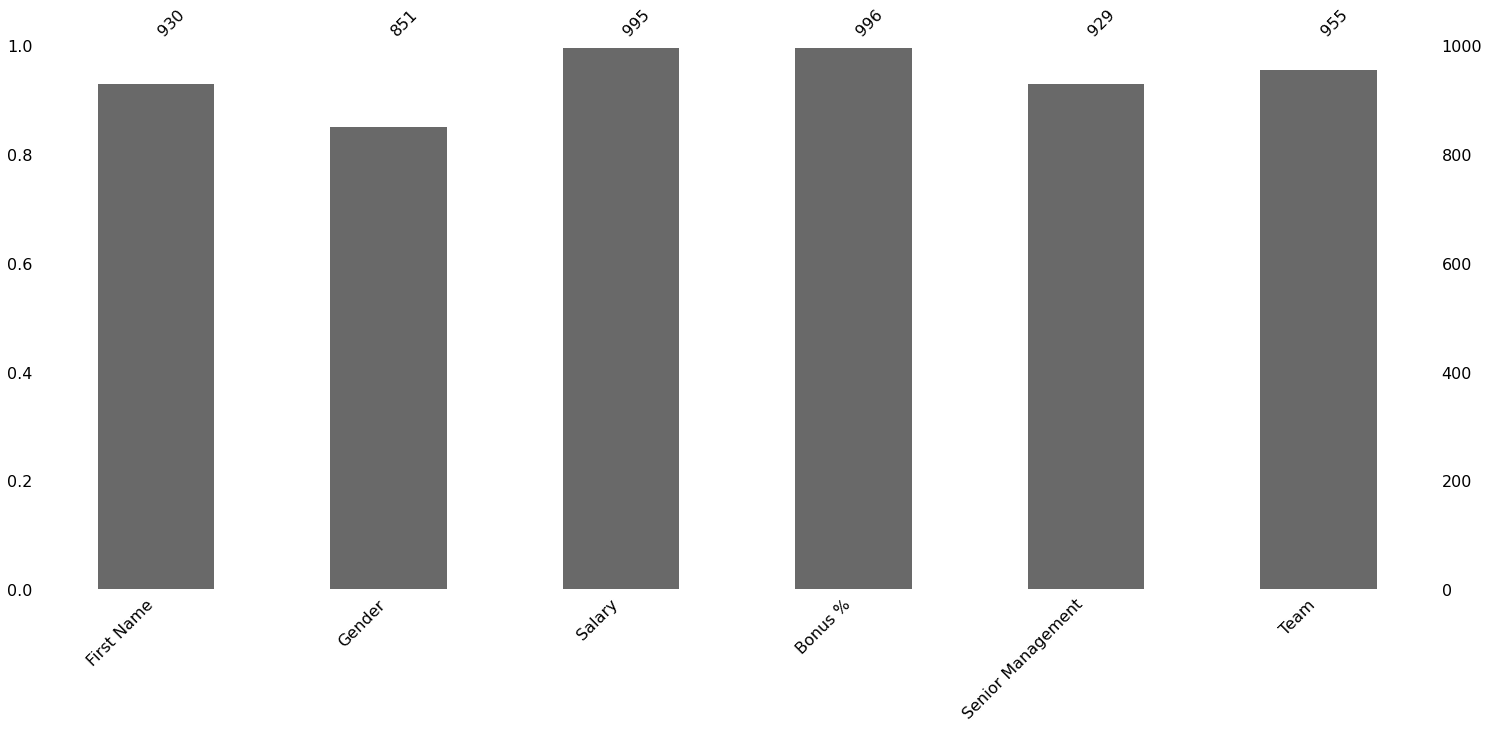

In [9]:
# Missing data bar chart 
msno.bar(df) 

Each bar represents a column, and the height of the bar indicates the "completeness" of the column. The y-axis on the left side of the chart scales from 0.0 to 1.0, where 0 represents 100% missingness and 1.0 represents 100% completeness. The scale on the right side of the chart shows the number of rows that corresponds to the percentage of missingness on the left side. Finally, on the top of the chart we can find a series of numbers that represent the total count of non-null values within each column.

In real world projects, this will probably be more than enough. How to handle missing data will often be based on the percentage of missingness within each column. However, if there is enough time, I would suggest that you also go through the following to better understand your data.

### Missing Data Mechanism

Another important factor to consider is the missing data mechanism. According to Rubin (1976), there are three mechanisms by which data can be missing:
- Missing Completely at Random (MCAR) – the probability of being missing is the same for all cases.
- Missing at Random (MAR) – the probability of being missing is the same only within groups defined by the observed data.
- Missing Not at Random (MNAR) – the probability of being missing varies for reasons that are unknown to us.

The **Little's MCAR test** (Little 1998) can be used to test for the MCAR assumption. Although it is not yet available in Python, we can get it from R using rpy2. This module enables R coding in a Python environment and makes R packages available to Python programmers. 

In [10]:
## Set up rpy2 ##

# Import R's base package
base = importr("base")
 
# Import R's utility packages
utils = importr("utils")
 
# Select mirror for R packages
utils.chooseCRANmirror(ind=1)

# For (automatic) translation of Pandas objects to R
pandas2ri.activate()
 
# Enable R magic
%load_ext rpy2.ipython
 
# Make Pandas dataframe accessible to R
globalenv['r_df'] = df

We can now get R functionality within our Python environment by using R magics. When wanting to execute a single line of R code, start the line with %R in the front. This can be useful when the cell contains both Python and R code. When wanting to execute multiple lines of R code, type %%R at the top of the cell so that the entire cell will be interpreted as R code. 
 
The template for installing R packages is: <br>
**utils.install_packages("package_name")**
 
You may also need to load the package before it can be used: <br>
**%R library(package_name)**

For the Little's MCAR test, we should install the *naniar* package. 

In [11]:
# Install naniar package
utils.install_packages("naniar")

# Load naniar
%R library(naniar);

R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/naniar_0.6.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2781177 bytes (2.7 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to cons

We now have access to the *mcar_test()* function. Let's see how it works.

In [12]:
%%R
# mcar_test on columns with missing data
r_dfMissing <- r_df[c("Salary","Bonus %")]
mcar_test(r_dfMissing) 

# A tibble: 1 x 4
  statistic    df p.value missing.patterns
      <dbl> <dbl>   <dbl>            <int>
1      2.67     2   0.263                3


The generated output includes a p-value. If this value is significant (p < .05), then data in the provided columns are either MAR or MNAR. If it is not significant (p > .5), then data are MCAR. <br> 

As you may have noticed, I only passed numeric columns to the function and this is because it won't work with other data types. To investigate missingness in the remaining columns we will need to use visualisation tools.

<AxesSubplot:>

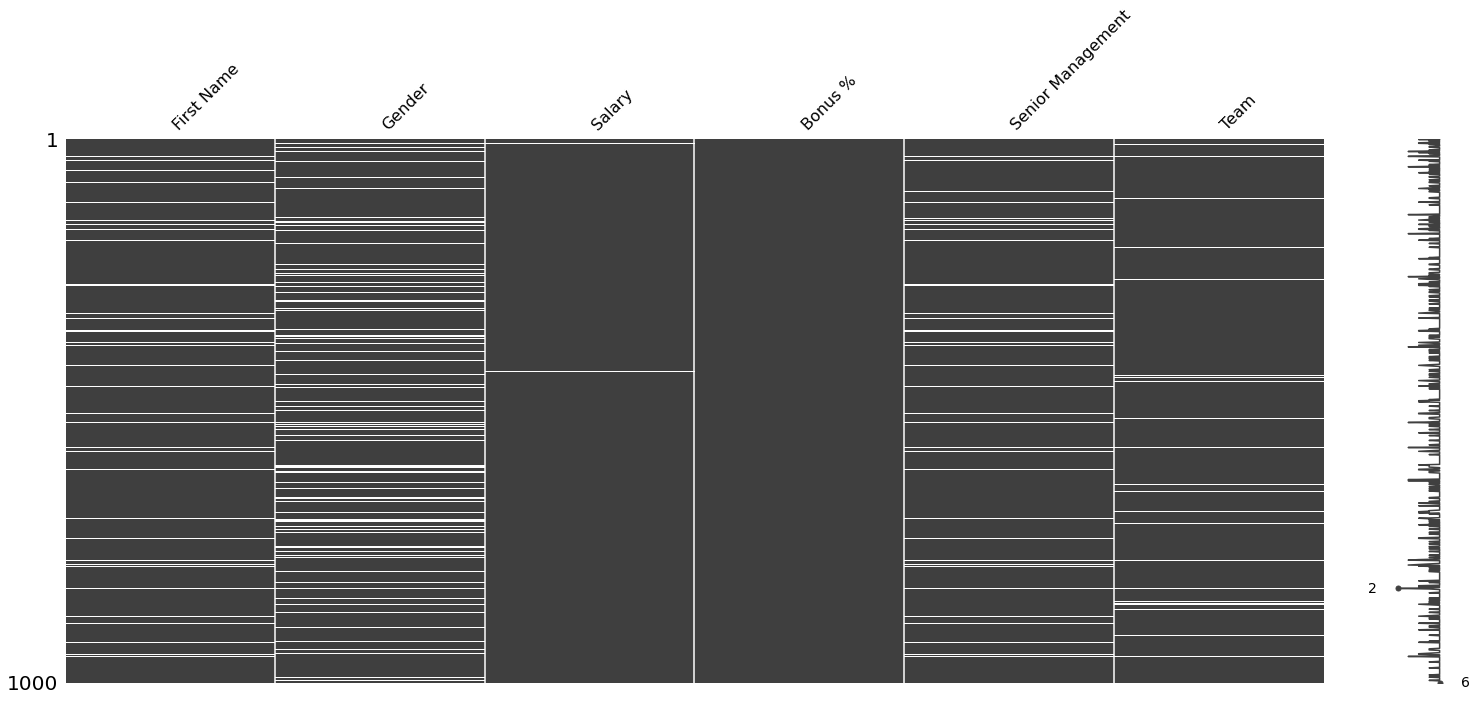

In [13]:
# Matrix plot
msno.matrix(df) 

The matrix plot gives information in respect to the position of missing values within a data frame which can be useful for quickly visualising patterns. The default colour for missing values is white and for non-missing values grey. The sparkline on the right side of the plot ranges from 0 to the total number of columns. When a row has no missing values, the line will be at the maximum right position. As missing values start to increase within that row the line will move towards the left.

<AxesSubplot:>

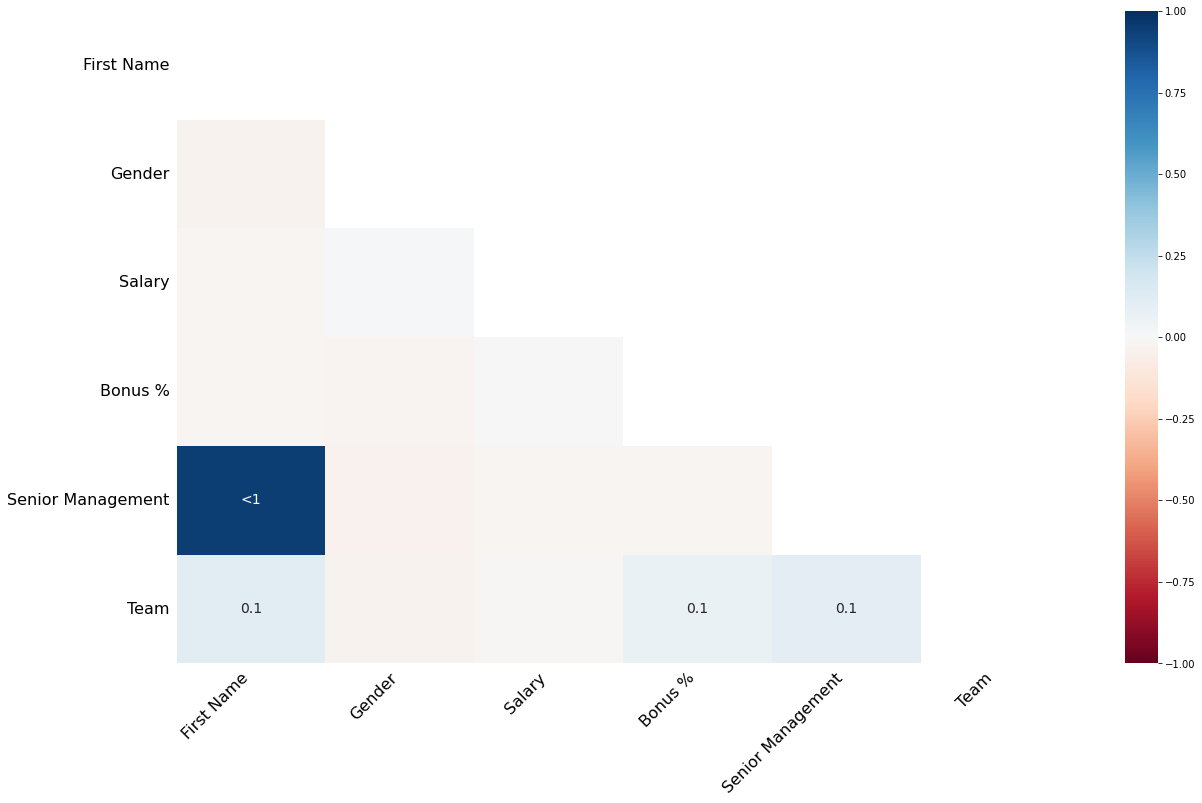

In [14]:
msno.heatmap(df)

The heatmap displays the correlations of the missingness (known as nullity correlation) between each column: how strongly the presence or absence of one variable affects the presence of another. A score of 1 indicates perfect positive correlation (i.e. if variable A has missing values, variable B will also). A score of -1 indicates a perfect negative correlation (i.e. if variable A has missing values, variable B will not). High correlation would be around 0.7 (or -0.7). Values close to 0 indicate poor relationship. This matrix is useful for understanding whether pairs of variables lack data for similar, opposite, or unrelated reasons.